In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from common import *
from preprocess import base

% matplotlib inline

In [2]:
root_dir = os.getcwd()

## An example
Link: http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

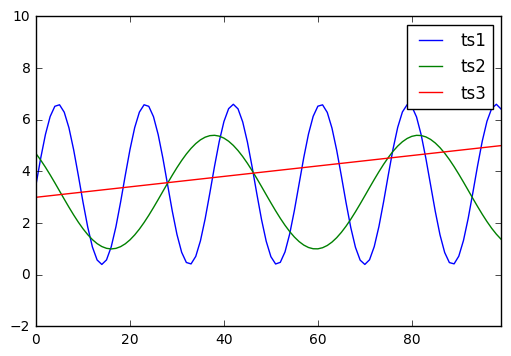

In [3]:
x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

In [8]:
def DTWDistance1(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def DTWDistanceW(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [9]:
from sklearn.metrics import classification_report

## classification
def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

##  clustering
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    index = list(np.arange(data.shape[1]))
    ris = random.sample(index,num_clust)
    centroids=data[:, ris] 
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind in np.arange(data.shape[1]):
            i = data[:, ind]
            min_dist=float('inf')
            closest_clust=None
            for c_ind in np.arange(centroids.shape[1]):
                j = centroids[:, c_ind]
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistanceW(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
                assignments[closest_clust].append(ind)
    
        print(assignments)
        #recalculate centroids of clusters
        for key in assignments:
            #print("key={}".format(key))
            clust_size = len(assignments[key])
            clust_sum=0
            for k in assignments[key]:
                #print("k={}".format(k))
                clust_sum=clust_sum+data[:,k]
            #print("clust_sum.shape{}".format(clust_sum.shape))
            centroids[:,key] = clust_sum/clust_size

    return centroids

## Analysis

In [6]:
data_dir = root_dir + "/data_0134/integrated_temp_sdmc_mean/"
filelist = base.get_files_csv(data_dir)
print(filelist)

file = filelist[0]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
print(data.columns)

['00_233_134_2016-05-20.csv' '01_233_134_2016-06-25.csv'
 '02_233_134_2016-07-11.csv' '03_233_134_2016-07-04.csv'
 '04_233_134_2016-07-02.csv' '05_233_134_2016-06-16.csv'
 '06_233_134_2016-07-13.csv' '07_233_134_2016-07-07.csv'
 '08_233_134_2016-06-19.csv' '09_233_134_2016-06-30.csv'
 '10_233_134_2016-06-29.csv']
Index(['hw_mean', 'sdmc_mean', 'zw_mean', 'ZD_CNT', 'ZD_LCG', 'ZD_TFG',
       'ZD_JHG', 'ZD_LLJ', 'ZD_SPEED'],
      dtype='object')


##### clustering
_the result is bad, because the new centroids is the mean of current cluster, however the time series are not at the same scale so that this projection will ruin the original space_

In [10]:
# clurster
data_dir = root_dir + "/data_0134/integrated_temp_sdmc_mean/"
filelist = base.get_files_csv(data_dir)
#print(filelist)

file = filelist[0]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
data = (data-data.mean())/(data.max()-data.min())
print(data.columns)
result = k_means_clust(data.as_matrix(),5,10,w=10)

Index(['hw_mean', 'sdmc_mean', 'zw_mean', 'ZD_CNT', 'ZD_LCG', 'ZD_TFG',
       'ZD_JHG', 'ZD_LLJ', 'ZD_SPEED'],
      dtype='object')
1
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
2
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
3
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
4
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
5
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
6
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
7
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
8
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
9
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}
10
{0: [4], 1: [1, 6, 8], 2: [3, 7], 3: [0, 2], 4: [5]}


##### calculate distance for integrated data

In [30]:
## ---------------- don't normalization data 
data_dir = root_dir + "/data_0134/integrated_temp_sdmc_mean/"
filelist = base.get_files_csv(data_dir)
#print(filelist)

file = filelist[10]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
print(data.columns)
varnames = data.columns
df_result = pd.DataFrame(columns = varnames, index=varnames)
for name_i in varnames:
    for name_j in varnames:
        dist = DTWDistanceW(data[name_i], data[name_j], 10)
        df_result.loc[name_i,name_j] = dist

print(df_result)

Index(['hw_mean', 'sdmc_mean', 'zw_mean', 'ZD_CNT', 'ZD_LCG', 'ZD_TFG',
       'ZD_JHG', 'ZD_LLJ', 'ZD_SPEED'],
      dtype='object')
           hw_mean sdmc_mean  zw_mean   ZD_CNT   ZD_LCG   ZD_TFG   ZD_JHG  \
hw_mean          0   1362.39  130.141  7675.86  18125.8  17808.7   4183.7   
sdmc_mean  1362.18         0  1466.77  8920.36  19270.7  19079.6  3727.51   
zw_mean    130.063   1467.04        0  7564.82  18009.8  17697.1  4216.53   
ZD_CNT      7676.2   8921.13  7565.06        0  10898.2  10236.6  9027.73   
ZD_LCG     18125.7   19267.8  18009.8  10900.2        0  4337.07  18816.1   
ZD_TFG     17808.7   19076.6  17697.1  10236.6  4315.33        0  18579.9   
ZD_JHG     4183.35    3706.4  4216.24  9030.98  18823.1  18579.9        0   
ZD_LLJ     1377.81   326.871  1480.98  9016.87  19419.6    19170  4288.87   
ZD_SPEED   1360.42   260.314  1464.38     9002  19390.7  19152.4  4178.69   

            ZD_LLJ ZD_SPEED  
hw_mean    1377.96   1360.6  
sdmc_mean  322.345  260.314  
zw_me

In [32]:
## ---------------- normalization data with: data = (data-data.mean())/data.std()

data_dir = root_dir + "/data_0134/integrated_temp_sdmc_mean/"
filelist = base.get_files_csv(data_dir)
#print(filelist)

file = filelist[10]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
data = (data-data.mean())/data.std()
print(data.columns)
varnames = data.columns
df_result = pd.DataFrame(columns = varnames, index=varnames)
for name_i in varnames:
    for name_j in varnames:
        dist = DTWDistanceW(data[name_i], data[name_j], 10)
        df_result.loc[name_i,name_j] = dist

print(df_result)

Index(['hw_mean', 'sdmc_mean', 'zw_mean', 'ZD_CNT', 'ZD_LCG', 'ZD_TFG',
       'ZD_JHG', 'ZD_LLJ', 'ZD_SPEED'],
      dtype='object')
           hw_mean sdmc_mean  zw_mean   ZD_CNT   ZD_LCG   ZD_TFG   ZD_JHG  \
hw_mean          0   44.9607  9.77222  50.9219  56.0057  55.3994  42.4533   
sdmc_mean  44.9089         0  45.5559  50.0721  48.7026  51.6746  28.4893   
zw_mean     9.7233   45.5916        0  50.4264  53.9718  54.6194   43.375   
ZD_CNT     50.9318   50.0735  50.4609        0  47.2089  50.8163    50.12   
ZD_LCG     56.0865   48.7026  54.1029  47.2366        0  44.1781  49.5122   
ZD_TFG     55.4026   51.6935   54.623  50.8218  44.1726        0  52.0917   
ZD_JHG     42.4044   28.4785   43.331    50.12  49.4098  52.0829        0   
ZD_LLJ     48.1509   26.2704  48.4604  50.4469  49.7454  51.2253   38.862   
ZD_SPEED   44.3204   9.19193   45.008  50.0059  48.4847  51.7455  26.4698   

            ZD_LLJ ZD_SPEED  
hw_mean    48.1707  44.3731  
sdmc_mean  26.2704  9.19193  
zw_me

In [33]:
## --------------------- normalization data with : (data-data.mean())/(data.max()-data.min())
data_dir = root_dir + "/data_0134/integrated_temp_sdmc_mean/"
filelist = base.get_files_csv(data_dir)
#print(filelist)

file = filelist[10]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
data = (data-data.mean())/(data.max()-data.min())
print(data.columns)
varnames = data.columns
df_result = pd.DataFrame(columns = varnames, index=varnames)
for name_i in varnames:
    for name_j in varnames:
        dist = DTWDistanceW(data[name_i], data[name_j], 10)
        df_result.loc[name_i,name_j] = dist

print(df_result)

Index(['hw_mean', 'sdmc_mean', 'zw_mean', 'ZD_CNT', 'ZD_LCG', 'ZD_TFG',
       'ZD_JHG', 'ZD_LLJ', 'ZD_SPEED'],
      dtype='object')
           hw_mean sdmc_mean  zw_mean   ZD_CNT   ZD_LCG   ZD_TFG   ZD_JHG  \
hw_mean          0   10.1228  2.95455  10.9093  14.2323  10.8555  10.6872   
sdmc_mean  10.1199         0  8.75419  4.18289  7.67011  2.36695   4.9068   
zw_mean    2.94632   8.75737        0   9.3362  12.5151   9.3316  9.82872   
ZD_CNT     10.9171   4.18293  9.34505        0  7.81617  3.98354   7.8843   
ZD_LCG     14.2529   7.67011  12.5451  7.81214        0  7.11653  10.0768   
ZD_TFG     10.8556   2.36775  9.33166  3.98381  7.07898        0  7.21334   
ZD_JHG     10.6772   4.85137  9.81891  7.88436  10.0561  7.21291        0   
ZD_LLJ       10.32   1.24692  8.92243  4.02822  7.65615  1.99109  5.76864   
ZD_SPEED   10.0518  0.561447   8.7237  4.39379  7.74298  2.75885  4.75007   

            ZD_LLJ  ZD_SPEED  
hw_mean    10.3212   10.0553  
sdmc_mean  1.24692  0.561447  
zw

In [36]:
## --------------------- normalization data with : (data-data.mean())/(data.max()-data.min())
data_dir = root_dir + "/data_0134/integrated_temp_sdmc_mean/"
filelist = base.get_files_csv(data_dir)
#print(filelist)

file = filelist[10]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
data = (data-data.mean())/(data.max()-data.min())
print(data.columns)
varnames = data.columns
win = int(0.25 * len(data))
print("win size is : ", win)
df_result = pd.DataFrame(columns = varnames, index=varnames)
for name_i in varnames:
    for name_j in varnames:
        dist = DTWDistanceW(data[name_i], data[name_j], win)
        df_result.loc[name_i,name_j] = dist

print(df_result)

Index(['hw_mean', 'sdmc_mean', 'zw_mean', 'ZD_CNT', 'ZD_LCG', 'ZD_TFG',
       'ZD_JHG', 'ZD_LLJ', 'ZD_SPEED'],
      dtype='object')
win size is :  322
           hw_mean sdmc_mean  zw_mean   ZD_CNT   ZD_LCG   ZD_TFG   ZD_JHG  \
hw_mean          0     7.552  1.37054  8.74068   10.003   10.595  8.57003   
sdmc_mean    7.552         0  6.67287  4.18287  7.35939  2.28306  3.48372   
zw_mean    1.37054   6.67273        0    7.448  8.56243  9.02538  8.08186   
ZD_CNT     8.74814   4.18287    7.448        0  4.40108  3.49915  7.80558   
ZD_LCG      10.003   7.35939  8.54083  4.40108        0  5.31257  9.40664   
ZD_TFG     10.5914   2.28319  9.02303  3.49915  5.31257        0  7.09099   
ZD_JHG     8.57003   3.48372  8.08186  7.80558  9.40664  7.09067        0   
ZD_LLJ     7.62484   1.12679  6.98541  4.02822  7.42803  1.95574  2.98146   
ZD_SPEED   7.56786  0.561447  6.70605  4.39358   7.4219  2.66481   3.3361   

            ZD_LLJ  ZD_SPEED  
hw_mean    7.62502   7.56786  
sdmc_mean  1.1

##### calculate distance for data : smooth_mean_interpolate_bin_mean

In [38]:
data_dir = root_dir + "/data_0134/smooth_mean_interpolate_bin_mean/"
filelist = base.get_files_csv(data_dir)
#print(filelist)

file = filelist[10]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
print(data.columns)
win = 50
varnames = data.columns
df_result = pd.DataFrame(columns = varnames, index=varnames)
for name_i in varnames:
    for name_j in varnames:
        dist = DTWDistanceW(data[name_i], data[name_j], win)
        df_result.loc[name_i,name_j] = dist

print(df_result)

Index(['ZD_CNT', 'ZD_LCG', 'ZD_TFG', 'ZD_JHG', 'ZD_LLJ', 'ZD_SPEED', 'ZX_BJ_1',
       'ZX_HW1_1', 'ZX_HW2_1', 'ZX_SDMC_1', 'ZX_BJ_2', 'ZX_HW1_2', 'ZX_HW2_2',
       'ZX_SDMC_2', 'ZX_BJ_3', 'ZX_HW1_3', 'ZX_HW2_3', 'ZX_SDMC_3', 'ZX_BJ_4',
       'ZX_HW1_4', 'ZX_HW2_4', 'ZX_SDMC_4', 'ZX_BJ_5', 'ZX_HW1_5', 'ZX_HW2_5',
       'ZX_SDMC_5', 'ZX_BJ_6', 'ZX_HW1_6', 'ZX_HW2_6', 'ZX_SDMC_6',
       'ZX_WD_1_1', 'ZX_WD_1_2', 'ZX_WD_1_3', 'ZX_WD_1_4', 'ZX_WD_1_5',
       'ZX_WD_1_6', 'ZX_WD_2_1', 'ZX_WD_2_2', 'ZX_WD_2_3', 'ZX_WD_2_4',
       'ZX_WD_2_5', 'ZX_WD_2_6', 'ZX_WD_3_1', 'ZX_WD_3_2', 'ZX_WD_3_3',
       'ZX_WD_3_4', 'ZX_WD_3_5', 'ZX_WD_3_6', 'ZX_WD_4_1', 'ZX_WD_4_2',
       'ZX_WD_4_3', 'ZX_WD_4_4', 'ZX_WD_4_5', 'ZX_WD_4_6', 'ZX_WD_5_1',
       'ZX_WD_5_2', 'ZX_WD_5_3', 'ZX_WD_5_4', 'ZX_WD_5_5', 'ZX_WD_5_6',
       'ZX_WD_6_1', 'ZX_WD_6_2', 'ZX_WD_6_3', 'ZX_WD_6_4', 'ZX_WD_6_5',
       'ZX_WD_6_6'],
      dtype='object')
            ZD_CNT   ZD_LCG   ZD_TFG   ZD_JHG   ZD_LLJ ZD_SPEED  ZX_

In [ ]:
data_dir = root_dir + "/data_0134/smooth_mean_interpolate_bin_mean/"
filelist = base.get_files_csv(data_dir)
#print(filelist)

file = filelist[10]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
print(data.columns)
varnames = data.columns
for name in varnames:
    result = []
    for name2 in varnames:
        result.append(DTWDistanceW(data[name], data[name2], 10))
    print(name, ":")
    name_list = list()
    dist_list = list()
    for i in np.arange(len(result)):
        if(result[i]<1000):
            name_list.append(varnames[i])
            dist_list.append(result[i])
    print(name_list)
    print(dist_list)

In [ ]:
### just leave final set

data_dir = root_dir + "/data_0134/smooth_mean_interpolate_bin_mean/"
filelist = base.get_files_csv(data_dir)
#print(filelist)

file = filelist[10]
data = pd.read_csv(data_dir+file)
del data['BTSJ']
data = (data - data.mean())/data.std()
print(data.columns)
varnames = data.columns
i_clust = 0
clust = {}
for name in varnames:
    result = []
    for name2 in varnames:
        result.append(DTWDistanceW(data[name], data[name2], 10))
    name_list = list()
    dist_list = list()
    for i in np.arange(len(result)):
        if(result[i]<1000):
            name_list.append(varnames[i])
            dist_list.append(result[i])
    print(name_list)
    find = False
    for key in clust:
        if set(name_list) == set(clust[key]):
            find = True
            break
    if find == False:
        clust[i_clust] = name_list
        i_clust +=1

print(clust)